# Fast Flux Gates on Fluxonium

In [2]:
import pathos
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scqubits as scq

## The Fluxonium Circuit

In [3]:
EJ   = 3.395
ECJ  = 0.479
EL   = 0.132

#Create an instance of the fluxonium circuit with the given parameters
fluxonium_yaml = f"""branches:
                   - [JJ, 1,2, EJ={EJ}, ECJ={ECJ}]
                   - [L,  1,2, EL={EL}]
                 """
               
circ = scq.Circuit(fluxonium_yaml, from_file=False, use_dynamic_flux_grouping=True)
circ.set_discretized_phi_range(var_indices=(1,), phi_range=(-4*np.pi, 4*np.pi))
circ.cutoff_ext_1 = 110

circ.Φ1 = 0.5

#Hierarchical diagonalization
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[6])

circ

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Circuit_1

#

## External Flux Control

### Definition

In [5]:
def ϕ1_control(t, args):
   
   """
   Parameters
   ----------

   t : float
            Time

   args : dict
            Dictionary containing the following parameters

            Am : float
                  Amplitude of the flux displacement below the sweet spot 
         
            Ap : float
                  Amplitude of the flux displacement above the sweet spot   
                  
         t_ramp_m : float
                     Time taken to ramp down the flux from the sweet spot
         
         t_wait : float
                     Waiting time between the ramp down and the ramp up
                  
         t_ramp_p : float
                     Time taken to ramp up the flux from the sweet spot

   Returns 
   ------- 
   ϕ1_ext : float 
            External flux at time t 

   """

   φm = args["φm"]
   φp = args["φp"]
   t_ramp_m = args["t_ramp_m"]
   t_wait = args["t_wait"]
   t_ramp_p = args["t_ramp_p"]
   
   #Start time for the ramp up
   t_ramp_up_start = 2*t_ramp_m + t_wait
      
   if (t<t_ramp_m):
      ϕ1_ext = 0.5 - t * φm / t_ramp_m
   
   elif t>=t_ramp_m and t<2*t_ramp_m:
      ϕ1_ext = (0.5 - φm) + (t-t_ramp_m)*φm/t_ramp_m
   
   elif t>=2*t_ramp_m and t<t_ramp_up_start:
      ϕ1_ext = 0.5
      
   elif t>=t_ramp_up_start and t<t_ramp_up_start+t_ramp_p:
      ϕ1_ext = 0.5 + (t-t_ramp_up_start)*φp/t_ramp_p
      
   elif t>=t_ramp_up_start+t_ramp_p and t<t_ramp_up_start+2*t_ramp_p:
      ϕ1_ext = (0.5 + φp) - (t-t_ramp_up_start-t_ramp_p)*φp/t_ramp_p
      
   else: ϕ1_ext = 0.5
   
   return ϕ1_ext
      

### Control Visualization

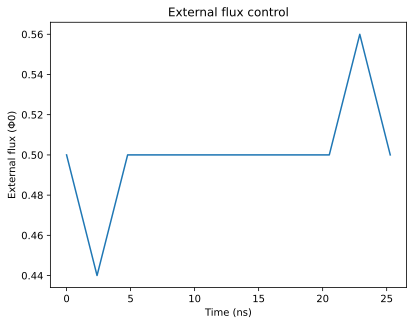

In [7]:
φ_amp = 0.06
φm    = φ_amp
φp    = φ_amp

# Parameters as in the paper to implement a Y/2 gate: wait sub-pulse times in nanoseconds
tz = 15.758
tp = 4.76

t_ramp_m = tp/2
t_wait   = tz
t_ramp_p = tp/2
t_tot    = 2*t_ramp_m + t_wait + 2*t_ramp_p

args = {"φm": φm, "φp": φp, "t_ramp_m": t_ramp_m, "t_wait": t_wait, "t_ramp_p": t_ramp_p}

t_list = np.linspace(0, t_tot, 10000)
ϕ1_ext = [ϕ1_control(t, args) for t in t_list]

plt.plot(t_list, ϕ1_ext)
plt.xlabel("Time (ns)")
plt.ylabel("External flux (Φ0)")
plt.title("External flux control")
plt.show()

#

## The Parametric Driving Function

In [5]:
# Call the hamiltonian_for_qutip_dynamics method to get the time-dependent Hamiltonian 
# in a form ready for QuTiP implementation[H0, [op1, time_dep_fn1],...]]

H_mesolve, *H_sym_ref = circ.hamiltonian_for_qutip_dynamics(
    free_var_func_dict={"Φ1":ϕ1_control},
    prefactor=2*np.pi
)

H_sym_ref

[-EJ*cos(1.0*θ1) + 0.5*EL*θ1**2 + 4.0*ECJ*Qs1, {19.7392088021787*EL: Φ1**2, -6.2831853071796*EL*θ1: Φ1}]

#

## Simulation Function

In [8]:
def fast_flux_control(tlist, circ_params, args, goal = "dynamics", c0 = 1, c1 = 0):
   
   """
   Parameters
   ----------
         
   circ_params : dict
            Dictionary containing the following parameters
            
            ECJ : float
                     Charging energy of the junction           
            EJ : float
                     Josephson energy of the junction       
            EL : float
                     Inductance of the junction              

   args : dict
            Dictionary containing the following parameters

            φ_amp : float
                     Amplitude of the flux displacement         
            tz : float
                     Twice the ramp duration (Convention in the paper)
            tp : float
                     Waiting time between the ramp down and the ramp up
                     
   goal : str
            The goal of the simulation. If "dynamics", the function computes the dynamics of the system.
            If "propagator", it computes the propagator of the system at the given time points.
            
   c0 : float
            Coefficient of the zero state in the initial state
            
   c1 : float
            Coefficient of the one state in the initial state  

   Returns 
   ------- 
   exp_x_t : list
             <X> expectation values at each time point in t_list
             
   exp_y_t : list
               <Y> expectation values at each time point in t_list            
               
   exp_z_t : list
               <Z> expectation values at each time point in t_list                  

   """
   ECJ = circ_params["ECJ"]
   EJ  = circ_params["EJ"]
   EL  = circ_params["EL"]
   
   fluxonium_yaml =f"""
                  branches:
                  - [JJ, 1,2, EJ={EJ}, ECJ={ECJ}]
                  - [L,  1,2, EL={EL}]
                    """
   
   #Create an instance of the fluxonium circuit with the given parameters                 
   fluxonium = scq.Circuit(fluxonium_yaml, from_file=False, use_dynamic_flux_grouping=True)
    
   fluxonium.set_discretized_phi_range(var_indices=(1,), phi_range=(-4*np.pi, 4*np.pi))
   fluxonium.cutoff_ext_1 = 110
   
   #Hierarchical diagonalization to reduce the Hilbert space dimension
   fluxonium.Φ1 = 0.5
   fluxonium.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[6])
   
   #Call the hamiltonian_for_qutip_dynamics method to get the time-dependent Hamiltonian in a form ready for QuTiP implementation[H0, [op1, time_dep_fn1],...]] 
   H_mesolve, *H_sym_ref = fluxonium.hamiltonian_for_qutip_dynamics(
       free_var_func_dict={"Φ1":ϕ1_control},
       prefactor=2*np.pi
   )
   
   t_ramp_m = args["tp"]/2
   t_ramp_p = args["tp"]/2
   t_wait   = args["tz"]
   
   φm = args["φ_amp"]
   φp = args["φ_amp"]
   
   args1 = {"φm": φm, "φp": φp, "t_ramp_m": t_ramp_m, "t_wait": t_wait, "t_ramp_p": t_ramp_p}
   
   if goal == "propagator":
      #Compute the propagator of the system at the given time points
      prop_list = propagator(H_mesolve, tlist, args=args1)
      return prop_list
   
   
   #Extract the lowest two eigenstates of the Hamiltonian
   eigvals, eigvecs = fluxonium.eigensys(evals_count=2)
   zero_05 = q.Qobj(eigvecs[:,0])
   one_05  = q.Qobj(eigvecs[:,1])
   
   #Initial state definition using the coefficients c0 and c1
   psi0 = c0 * zero_05 + c1 * one_05
   rho0 = psi0 * psi0.dag() 
   
   #Define the X, Y, and Z operators for the 2D subspace spanned by zero_05 and one_05
   plus    = (zero_05 + one_05)/np.sqrt(2)
   minus   = (zero_05 - one_05)/np.sqrt(2)
   plus_y  = (zero_05 + 1j * one_05)/np.sqrt(2)
   minus_y = (zero_05 - 1j * one_05)/np.sqrt(2)
   
   x_op    = plus * plus.dag() - minus * minus.dag()
   y_op    = plus_y * plus_y.dag() - minus_y * minus_y.dag()
   z_op    = zero_05 * zero_05.dag() - one_05 * one_05.dag()

   result = q.mesolve(H_mesolve, rho0, tlist, e_ops=[x_op, y_op, z_op], args=args1)  
   
   return result.expect[0], result.expect[1], result.expect[2]

#

## Illustration: Y/2 gate

In [9]:
#Circuit parameters
EJ   = 3.395
ECJ  = 0.479
EL   = 0.132

circ_params = {"EJ": EJ, "ECJ": ECJ, "EL": EL}

#Drive parameters
φ_amp = 0.0248

#Total ramp and wait times as in the paper
tp = 4.76
tz = 12.73

args = {"φ_amp": φ_amp, "tz": tz, "tp": tp}

t_ramp_m = tp/2
t_ramp_p = tp/2
t_wait   = tz
tg = 2*t_ramp_m + t_wait + 2*t_ramp_p

tlist = np.linspace(0, tg, 1000) 

#Initial state coefficients
c0 = 1
c1 = 0

#Dynamics of the given state
exp_x_t, exp_y_t, exp_z_t = fast_flux_control(tlist, circ_params, args, goal = "dynamics", c0 = c0, c1 = c1) 

#Computing the propagator
prop_list = fast_flux_control(tlist, circ_params, args, goal = "propagator")


### Dynamics during the Y/2 Gate

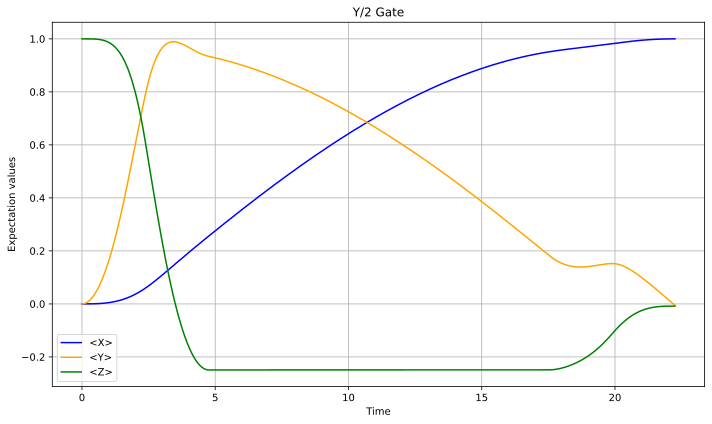

In [10]:
#Plot just the expectation values in one figure
fig = plt.figure(figsize=(10, 6))

plt.plot(tlist, exp_x_t, label="<X>", color="blue")
plt.plot(tlist, exp_y_t, label="<Y>", color="orange")
plt.plot(tlist, exp_z_t, label="<Z>", color="green")
plt.xlabel("Time")
plt.ylabel("Expectation values")
plt.title("Y/2 Gate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### The Propagator

In [12]:
# Extract the propagator for the full evolution
# and set the global phase so that the first element is real
prop_final_full = prop_list[-1]/(prop_list[-1][0,0]/np.abs(prop_list[-1][0,0]))

# Truncate to the 2D subspace
prop_qubit_final = prop_final_full.full()
prop_qubit_final = prop_qubit_final[:2,:2]
prop_qubit_final = Qobj(prop_qubit_final/(prop_qubit_final[0,0]/np.abs(prop_qubit_final[0,0])))

prop_qubit_final



Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.70415754+0.j         -0.71003314+0.00386663j]
 [ 0.71003314-0.00386387j  0.70411588-0.00766635j]]

In [13]:
# Gate fidelity calculation
Y_2_gate = Qobj(np.array([[1, -1], [1, 1]]) / np.sqrt(2))

gate_fidelity = np.abs((Y_2_gate * prop_qubit_final.dag()).tr())**2 / 4

gate_fidelity

0.9999678137232118

#

## Sweeps

#### $\varphi_\text{amp}$ - $t_z$ Sweep

In [14]:
import numpy as np
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

#Circuit parameters
EJ   = 3.395
ECJ  = 0.479
EL   = 0.132

circ_params = {"EJ": EJ, "ECJ": ECJ, "EL": EL}


#Total ramp time
tp = 4.76

t_ramp_m = tp/2
t_ramp_p = tp/2

#Initial state coefficients
c0 = 1
c1 = 0

#Mesh creation
φ_amp_values  = np.linspace(0, 0.06, 100)     
tz_values = np.linspace(0, 100, 100) 

def worker(φ_amp, tz):
    args = {"φ_amp": φ_amp, "tz": tz, "tp": tp}
    t_wait = tz   
    tlist = np.linspace(0, 2*t_ramp_m + t_wait + 2*t_ramp_p, 1000) 
    exp_x, exp_y, exp_z = fast_flux_control(tlist, circ_params, args, goal = "dynamics", c0 = c0, c1 = c1)
    
    # take the final value at t = tlist[-1]
    return (φ_amp, tz, exp_x[-1], exp_y[-1], exp_z[-1])

# Parallel computation over the grid
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(worker, φ, tz) 
               for φ, tz in itertools.product(φ_amp_values, tz_values)]
    for fut in as_completed(futures):
        results.append(fut.result())

# Organize into 2D arrays without manual sorting
X_mat = np.zeros((len(φ_amp_values), len(tz_values)))
Y_mat = np.zeros_like(X_mat)
Z_mat = np.zeros_like(X_mat)

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

 /tmp/ipykernel_2648464/1775746947.py: 4ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_2648464/1775746947.py: 5ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_2648464/1775746947.py: 6

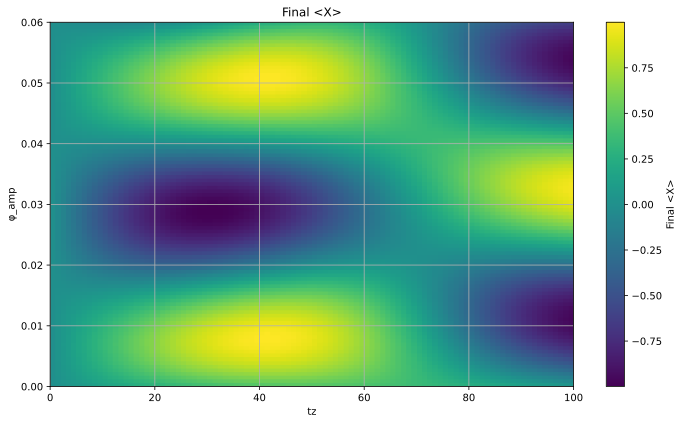

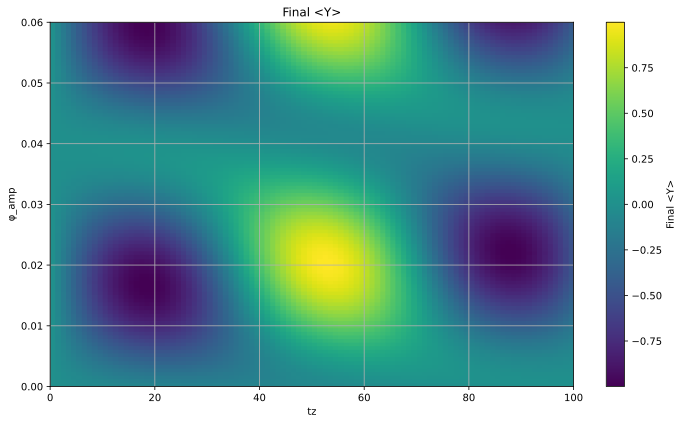

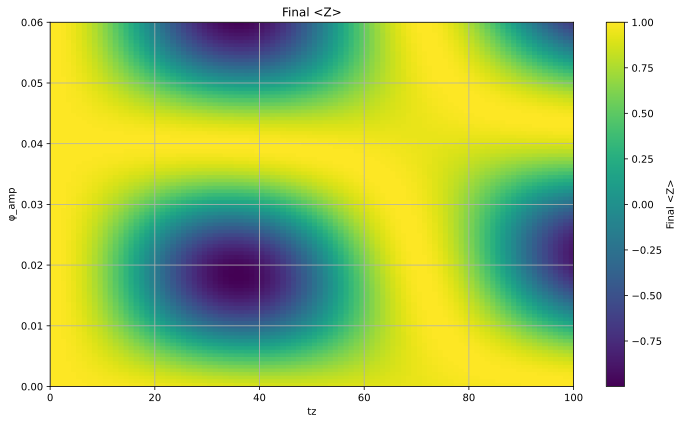

In [94]:
for φ_amp, tz, x_val, y_val, z_val  in results:
    i = np.argwhere(φ_amp_values == φ_amp)[0, 0]
    j = np.argwhere(tz_values == tz)[0, 0]
    X_mat[i, j] = x_val
    Y_mat[i, j] = y_val
    Z_mat[i, j] = z_val

# Plotting the results with tz on the x-axis and φ_amp on the y-axis (mat must be transposed)
X_mat = np.transpose(X_mat)
Y_mat = np.transpose(Y_mat)
Z_mat = np.transpose(Z_mat)

for mat, name in [(X_mat, 'Final <X>'), (Y_mat, 'Final <Y>'), (Z_mat, 'Final <Z>')]:
   plt.figure(figsize=(10, 6))
   plt.imshow(mat, extent=[tz_values[0], tz_values[-1], φ_amp_values[0], φ_amp_values[-1]], aspect='auto', origin='lower')
   plt.colorbar(label=name)
   plt.title(name)
   plt.xlabel("tz")
   plt.ylabel("φ_amp")
   plt.grid()
   plt.tight_layout()     
      

plt.show()

In [95]:
#Find the maximum value of <X> and the corresponding φ_amp and tz
max_x = np.max(X_mat)
max_x_index = np.unravel_index(np.argmax(X_mat), X_mat.shape)
max_φ_amp = φ_amp_values[max_x_index[0]]
max_tz = tz_values[max_x_index[1]]
max_y = Y_mat[max_x_index]
max_z = Z_mat[max_x_index]

#Print all values up to 5 decimal places
print(f"Maximum <X>: {max_x:.5f}", "at φ_amp:", f"{max_φ_amp:.5f}", "and tz:", f"{max_tz:.5f}") 
print(f"Corresponding <Y>: {max_y:.5f}")
print(f"Corresponding <Z>: {max_z:.5f}")

Maximum <X>: 0.99991 at φ_amp: 0.05091 and tz: 41.41414
Corresponding <Y>: -0.00039
Corresponding <Z>: -0.01365


 /tmp/ipykernel_2648464/1889295987.py: 38ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_2648464/1889295987.py: 39ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_2648464/1889295987.py: 40

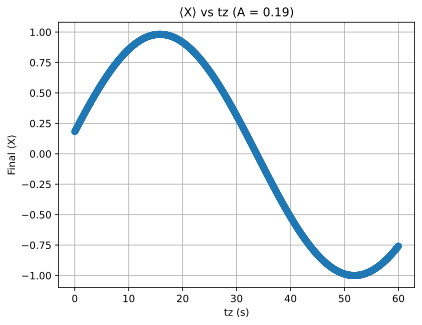

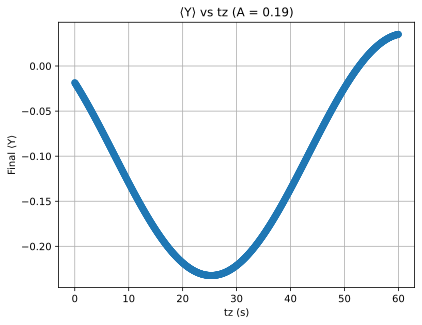

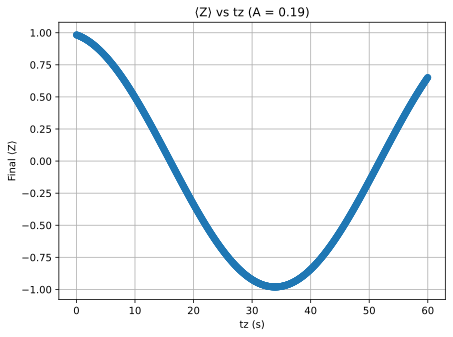

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Assume fast_flux_control is already defined/imported

# Circuit parameters
EJ   = 3.395
ECJ  = 0.479
EL   = 0.132
circ_params = {"EJ": EJ, "ECJ": ECJ, "EL": EL}

# Drive parameters
A_fixed = 0.18     # single amplitude value to hold fixed

# Total ramp time (tp) and zero wait-time baseline (tz=0)
tp = 4.76

# Time‐grid for the control waveform
t_ramp = tp/2
t_wait = 0 

# Initial state
c0, c1 = 1, 0

# Sweep tz only
tz_values = np.linspace(0, 60, 1000)

# Pre‐allocate arrays for final expectation values
X_final = np.zeros_like(tz_values)
Y_final = np.zeros_like(tz_values)
Z_final = np.zeros_like(tz_values)

# Loop over tz
for idx, tz in enumerate(tz_values):
    args = {"A": A_fixed, "tz": tz, "tp": tp}
    tlist = np.linspace(0, 2*t_ramp + tz + 2*t_ramp, 1000)  
    exp_x, exp_y, exp_z = fast_flux_control(c0, c1, tlist, circ_params, args)
    # grab the last time‐point
    X_final[idx] = exp_x[-1]
    Y_final[idx] = exp_y[-1]
    Z_final[idx] = exp_z[-1]

# Plot each expectation vs tz
plt.figure()
plt.plot(tz_values, X_final, marker='o', linestyle='-')
plt.xlabel('tz (s)')
plt.ylabel('Final ⟨X⟩')
plt.title(f'⟨X⟩ vs tz (A = {A_fixed})')
plt.grid(True)

plt.figure()
plt.plot(tz_values, Y_final, marker='o', linestyle='-')
plt.xlabel('tz (s)')
plt.ylabel('Final ⟨Y⟩')
plt.title(f'⟨Y⟩ vs tz (A = {A_fixed})')
plt.grid(True)

plt.figure()
plt.plot(tz_values, Z_final, marker='o', linestyle='-')
plt.xlabel('tz (s)')
plt.ylabel('Final ⟨Z⟩')
plt.title(f'⟨Z⟩ vs tz (A = {A_fixed})')
plt.grid(True)

plt.tight_layout()
plt.show()
